# Fine-tuning di un modello di linguaggio neurale (Neural Language Model)

Selezionare un neural language model tra quelli trattati durante il corso e condurre un processo di fine-tuning per un totale di 6 epoche. Per questa fase, è richiesto di:

- presentare le curve di loss relative al training e al validation set
- riportare le prestazioni del modello sul validation set al termine di ciascuna epoca
- valutare il modello sul test set al termine della sesta epoca.

In [1]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device in uso: {device}")
# verifico che l'MPS support sia in funzione (Metal Performance Shaders backend for GPU training acceleration on Mac: https://developer.apple.com/metal/pytorch/)
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")

Device in uso: mps


In [2]:
#!pip install transformers
#!pip install --upgrade datasets
#!pip install evaluate
#!pip install accelerate
#!pip install hf_xet
#pip install --upgrade transformers datasets
#pip install --upgrade torch
#pip install --upgrade torchvision

In [3]:
import os

import numpy as np
import pandas as pd

import datasets
import evaluate
import seaborn as sns

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## Caricamento dei dati

In [4]:
training_path = "Dataset/Training/"
test_path = "Dataset/Test/"
val_path = "Dataset/Validation/"

In [5]:
# funzione di estrazione delle informazioni dei file
def estrai_doc(path, lista_doc):
    documents = os.listdir(path)

    for document in documents:

        # mi assicuro di prendere solo i file txt
        if document.endswith(".txt"):
            
            data = open(path + document, 'r')
            text = data.read()
            # creo un dizionario che conterrà sentence, label (autrici) e id del documento
            info_doc = {}
            id_doc = (document.split('.')[0]).split("/")[-1]
            labels_doc = id_doc.split('_')[0]
            info_doc["id_doc"] = id_doc #utile per un'eventuale error analysis
            info_doc["label"] = labels_doc
            info_doc["sentence"] = text

            # appendo le informazioni estratte nel dizionario
            lista_doc.append(info_doc)
    
    return lista_doc

In [6]:
# Estraggo i documenti e loro informazioni, creo le liste per le analisi successive

train_data = []
test_data = []
val_data = []

train_data= estrai_doc(training_path, train_data)
test_data = estrai_doc(test_path, test_data)
val_data = estrai_doc(val_path, val_data)

In [7]:
train_data[0]

{'id_doc': 'serao_54_training',
 'label': 'serao',
 'sentence': "Anzi, il nostro amore era senza fatti. Ci vedevamo troppo raramente, perchè le due esistenze si unissero nella fusione degli avvenimenti quotidiani. Parlavamo di amore, pianamente, soavemente, anzi con quella cautela delle persone che molto soffrono, che molto temono di soffrire: e vi era in ogni suo sguardo tanta effusione spirituale: vi era nelle sue mani che tenevano le mie quasi senza stringerle, tanto fluido di affetto: vi era nella sua voce tale onda di amore; che io mi scordava tutto il passato, che io non aveva più paura dell'avvenire, e mi sentivo accanto a Giustino Morelli assolutamente felice."}

In [8]:
print(len(train_data))
print(len(test_data))
print(len(val_data))


3000
300
300


In [9]:
# Conversione da lista di dizionari a dataset
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))
val = datasets.Dataset.from_pandas(pd.DataFrame(data=val_data))

In [10]:
# Stampo 'train' per vedere come è formattato
print(train)
print()
print("Esempio di testo:", train['sentence'][2])
print()
print("Esempio di label:", train['label'][2])
print()
print("Esempio di id:", train['id_doc'][2])
print()

# Shape dei dati di train, dev e test
print("Dimensione dei training, development and test sets:")
print("Train:", train.shape)
print("Dev:", val.shape)
print("Test:", test.shape)

Dataset({
    features: ['id_doc', 'label', 'sentence'],
    num_rows: 3000
})

Esempio di testo: Oh! senza di essa nulla avrei compreso della creazione che mi stava innanzi, ch’ella mi spiegava con quella sua anima aperta, calda, amante, spargendo su tutto la luce, mettendo in tutto la vita. L’istruzione insensibile che ricevevo non era una lezione, era l’attività stessa del vivere e del pensare che andavo compiendo sotto i suoi occhi.

Esempio di label: neera

Esempio di id: neera_121_training

Dimensione dei training, development and test sets:
Train: (3000, 3)
Dev: (300, 3)
Test: (300, 3)


## Caricamento del modello

Modello scelto: encoder -> Bert base italian cased

(base: dimensione del modello -> 110M di parametri; cased: il testo non viene messo tutto in lowercase e non toglie gli accenti)


In [11]:
# numero labels = 3 (le tre autrici)
labels = ["colombi", "neera", "serao"]

# Creo un dizionario di mapping fra le labels come stringhe e le label numeriche
str_to_int = {label: num for num, label in enumerate(labels)}

In [12]:
# Seleziono il modello
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello per la classificazione
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))
# Lo sposto sulla GPU
model.to(device)

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing dei dati

Tokenizzo i documenti e converto le label in valori numerici

Imposto "max_length = 512" (sequenza di addestramento di Bert) e "truncation=True", assumendo che, anche divisi in subwords, i miei paragrafi dovrebbero essere meno lunghi. Se superano la max_length, vengono troncati.

In [13]:
# Faccio una prova su uno dei documenti del dataset per vedere se funziona tutto
tokenizer(train[0]["sentence"], padding=True, truncation=True, max_length=512)

{'input_ids': [102, 11781, 1307, 162, 1149, 3711, 529, 853, 3437, 697, 654, 19624, 185, 1740, 14726, 1307, 6303, 199, 538, 3903, 30880, 516, 223, 1290, 1873, 403, 9225, 483, 14223, 21502, 697, 7628, 2170, 120, 3711, 1307, 27615, 255, 1307, 245, 3574, 255, 1307, 8328, 153, 899, 19157, 324, 1022, 158, 617, 23863, 1307, 158, 617, 16806, 169, 120, 16343, 1587, 126, 320, 529, 139, 818, 415, 8363, 11572, 797, 3055, 7044, 1587, 320, 529, 841, 1373, 1313, 158, 21166, 169, 199, 1388, 1937, 853, 10073, 1704, 125, 1307, 1609, 22228, 120, 16367, 1587, 320, 529, 403, 497, 2954, 1251, 9648, 120, 3711, 5193, 158, 642, 318, 5124, 208, 187, 564, 162, 2376, 1307, 158, 642, 212, 1156, 353, 3143, 298, 1553, 13794, 1307, 126, 318, 17455, 6481, 111, 10252, 3090, 11017, 1788, 5446, 3561, 697, 103], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Tokenizzazione dei dati

In [14]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize(batch):
    tokens = tokenizer(batch['sentence'], padding=True, truncation=True, max_length=512)
    tokens['label'] = [str_to_int[label] for label in batch["label"]]

    return tokens

train = train.map(tokenize, batched=True)
val = val.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

train.set_format('numpy', columns=['input_ids', 'attention_mask', 'label'])
val.set_format('numpy', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('numpy', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Addestramento del modello

Definisco Training arguments, metriche e trainer (oggetto della libreria Transformers che processa tutti gli argomenti e, tramite il metodo .train() fa partire l'addestramento.)

### Training arguments

In [15]:
# Trainer

num_epochs = 6

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    eval_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

### Metrica

Definiamo una funzione compute_metrics che prende input le predictions del modello e:

- applica un argmax alle predictions;
- calcola l'F-Score fra le predictions e le true labels.

In [16]:
def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

### Trainer

A seguito della fase di training, con trainer.save_model() specifichiamo dover voler salvare il modello.

In [17]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("Bert")

/var/folders/dy/_vzc_bl12fv1jxcs5db4wmwh0000gn/T/ipykernel_3005/3485811681.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1
1,0.500900,1.181714,0.688177
2,0.141400,1.512529,0.682161
3,0.042000,1.904724,0.665320
4,0.009900,1.525543,0.735531
5,0.001400,1.760435,0.715480
6,0.000300,1.713900,0.733776


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

## Evaluation del modello

### Monitoraggio della loss

/var/folders/dy/_vzc_bl12fv1jxcs5db4wmwh0000gn/T/ipykernel_3005/3703003683.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, log_df], ignore_index=True)


<Axes: xlabel='Epoch', ylabel='Loss'>

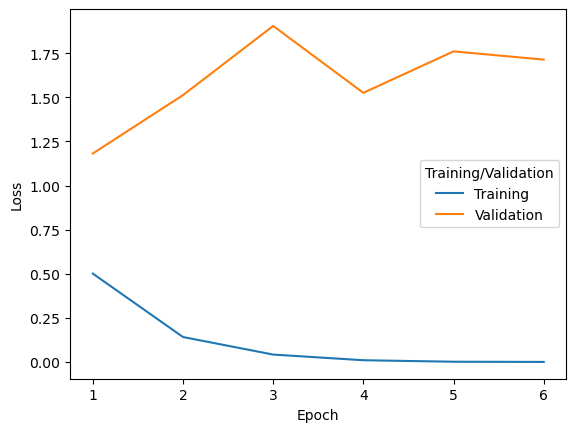

In [18]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]

    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Training"]})
    df = pd.concat([df, log_df], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Validation"]})
    df = pd.concat([df, log_df], ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")

## Calcolo performance sul test set

Applicando il metodo *.predict()* sul nostro test set, otteniamo come output le prediction del modello, assieme alle metriche di valutazione (e.g. weighted F1)

In [19]:
output_predictions = trainer.predict(test)
print(output_predictions)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


PredictionOutput(predictions=array([[-1.02197504e+00, -2.93828821e+00,  3.79116035e+00],
       [ 3.01446366e+00, -2.61026001e+00, -7.19704330e-01],
       [-1.70013070e+00, -1.22713697e+00,  3.18389893e+00],
       [ 2.03713202e+00,  5.32798886e-01, -2.61685395e+00],
       [ 3.68376970e+00, -1.87646639e+00, -2.02846670e+00],
       [ 1.42643249e+00,  2.18569350e+00, -3.30762362e+00],
       [ 3.73665237e+00, -1.71601331e+00, -2.35667419e+00],
       [ 3.81250358e+00, -1.69493580e+00, -2.46577096e+00],
       [ 3.28398180e+00, -6.39538229e-01, -2.76902628e+00],
       [ 1.72724068e+00, -3.56894207e+00,  1.45494330e+00],
       [ 3.85915899e+00, -1.91027415e+00, -2.29437256e+00],
       [ 3.81816125e+00, -2.29839969e+00, -1.69144392e+00],
       [ 2.37848854e+00,  9.93308365e-01, -3.18717194e+00],
       [ 3.81138396e+00, -2.02798343e+00, -1.99318027e+00],
       [-1.31925166e+00,  1.48583066e+00,  4.87525016e-01],
       [-4.43064958e-01,  2.95908332e+00, -2.10966039e+00],
       [ 3.

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.96      0.71       100
           1       0.93      0.40      0.56       100
           2       0.83      0.71      0.76       100

    accuracy                           0.69       300
   macro avg       0.77      0.69      0.68       300
weighted avg       0.77      0.69      0.68       300


Confusion Matrix:


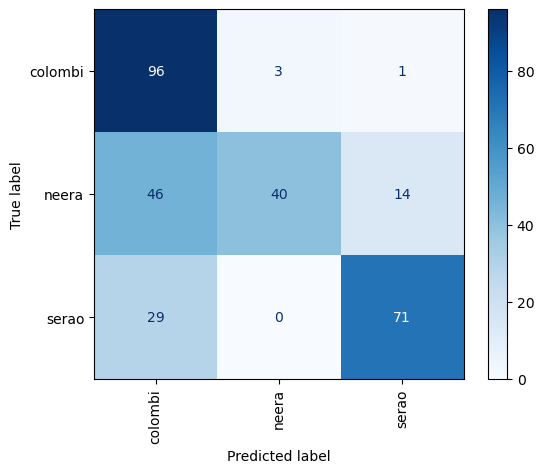

In [ ]:
y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)
# cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

# print("Classification Report:")
# print(report)
# print()

# print("Confusion Matrix:")
# print(cm)

# Recupera la lista delle etichette nell'ordine corretto
labels = ["colombi", "neera", "serao"]
str_to_int = {label: num for num, label in enumerate(labels)}
int_to_str = {v: k for k, v in str_to_int.items()}

# Ottengo i nomi delle etichette ordinati per indice numerico
display_labels = [int_to_str[i] for i in range(len(labels))]

# Stampo la matrice di confusione con i nomi delle etichette
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=display_labels, 
    xticks_rotation='vertical', 
    cmap='Blues'
)

print("Classification Report:")
print(report)
print()
print("Confusion Matrix:")
print(cm)